<a href="https://colab.research.google.com/github/ashworks1706/AI-Solar-Panel/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Self Rotatory Solar Panel

This Project utilizes various vision models to train on planet sun labelled datasets and perform validation checks to determine which model performs the best and converts the best model to tinyML Model to make it usable by microcontroller

## Installing Dependencies

In [ ]:
%pip install --upgrade pip

In [ ]:
%pip install inference  suncalc  roboflow ultralytics torch matplotlib geocoder numpy ffmpeg 

## Importing Libraries

In [10]:
import cv2
import json
import math
import numpy as np
import os
import shutil
import time
import yaml
from datetime import datetime, timezone, timedelta
from PIL import Image
import geocoder
import locale
import matplotlib.pyplot as plt
# from roboflow import Roboflow
from suncalc import get_position
import supervision as sv
import torch
from ultralytics import YOLO

from inference import get_model

# Commented out Google Colab-specific imports
# from google.colab import drive
# from google.colab.patches import cv2_imshow
# from google.colab import userdata

## Setting up Environment

In [ ]:
# Google Colab
# api_key = userdata.get('ROBOFLOW_API_KEY')

# Local (appConfig.json required)
try:
    with open('appConfig.json') as config_file:
        config = json.load(config_file)
    api_key = config.get('ROBOFLOW_API_KEY', '')
except FileNotFoundError:
    print("appConfig.json not found. Please make sure the file exists in the same directory as the script.")
    api_key = ''
except json.JSONDecodeError:
    print("Error decoding appConfig.json. Please make sure it's a valid JSON file.")
    api_key = ''

In [ ]:
# drive.mount('/content/drive')

In [ ]:
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# os.environ['NO_ALBUMENTATIONS_UPDATE '] = '1'


In [ ]:
# print("TensorFlow version:", tf.__version__)
# print("GPU Available:", tf.config.list_physical_devices())


In [ ]:
# # List available GPUs
# physical_devices = tf.config.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))

# if len(physical_devices) > 0:
# # Enable memory growth for all GPUs
#   for gpu in physical_devices:
#       tf.config.experimental.set_memory_growth(gpu, True)

#   # Use all available GPUs
#   tf.config.set_visible_devices(physical_devices, 'GPU')

#   # Enable XLA (Accelerated Linear Algebra) optimization
#   tf.config.optimizer.set_jit(True)

#   tf.config.set_visible_devices(physical_devices[0], 'GPU')

#   # Enable mixed precision training

#   policy = mixed_precision.Policy('mixed_float16')
#   mixed_precision.set_global_policy(policy)

#   print("GPU optimization settings applied successfully")
# else:
#     print("No GPU available. Running on CPU.")

## Utils

In [ ]:

class ModelEvaluationDisplay:
    def __init__(self, metrics, plots_path):
        self.metrics = metrics
        self.plots_path = plots_path

    def display_overall_metrics(self):
        mAP50_95 = self.metrics.box.map
        mAP50 = self.metrics.box.map50
        precision = np.mean(self.metrics.box.p)
        recall = np.mean(self.metrics.box.r)

        print("\n## Model Evaluation Metrics\n")
        print("| Metric | Value | Description |")
        print("|--------|-------|-------------|")
        print(f"| mAP50-95 | {mAP50_95:.3f} | Mean Average Precision across IoU thresholds 0.50-0.95 |")
        print(f"| mAP50 | {mAP50:.3f} | Mean Average Precision at IoU threshold 0.50 |")
        print(f"| Precision | {precision:.3f} | Overall precision across all classes |")
        print(f"| Recall | {recall:.3f} | Overall recall across all classes |")

    def display_class_specific_metrics(self):
        print("\n## Class-specific Performance\n")
        print("| Class | Precision | Recall | mAP50 | mAP50-95 |")
        print("|-------|-----------|--------|-------|----------|")
        for i, (p, r, map50, map) in enumerate(zip(self.metrics.box.p, self.metrics.box.r,
                                                   self.metrics.box.ap50, self.metrics.box.ap)):
            print(f"| class_{i} | {p:.3f} | {r:.3f} | {map50:.3f} | {map:.3f} |")

    def display_speed_metrics(self):
        print("\n## Speed Metrics\n")
        print(f"- Preprocess time: {self.metrics.speed['preprocess']:.1f}ms per image")
        print(f"- Inference time: {self.metrics.speed['inference']:.1f}ms per image")
        print(f"- Postprocess time: {self.metrics.speed['postprocess']:.1f}ms per image")

    # def display_plot(self, plot_name, description):
    #     img = cv2.imread(self.plots_path + plot_name)
    #     resized_img = cv2.resize(img, (600, 400))
    #     cv2_imshow(resized_img)
    #     print(f"\n{description}\n")
    def display_plot(self, plot_name, description):
        img = cv2.imread(self.plots_path + plot_name)
        resized_img = cv2.resize(img, (600, 400))
        
        # Convert from BGR to RGB color space
        rgb_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
        
        # Display using matplotlib
        plt.figure(figsize=(10, 6))
        plt.imshow(rgb_img)
        plt.title(description)
        plt.axis('off')
        plt.show()
        print(f"\n{description}\n")


    def display_pr_curve(self):
        self.display_plot("PR_curve.png", "The PR curve illustrates the trade-off between precision and recall at various confidence thresholds, indicating model performance across different operating points.")

    def display_precision_curve(self):
        self.display_plot("P_curve.png", "The Precision curve shows how precision varies with confidence threshold for each class, helping identify optimal detection thresholds.")

    def display_recall_curve(self):
        self.display_plot("R_curve.png", "The Recall curve demonstrates how recall changes with confidence threshold, showing the model's ability to find all relevant objects.")

    def display_confusion_matrix(self):
        self.display_plot("confusion_matrix.png", "The confusion matrix displays the model's classification performance across all classes, showing true positives, false positives, and false negatives.")

    def display_validation_predictions(self):
        self.display_plot("val_batch0_pred.jpg", "These images show the model's actual predictions on validation data, with bounding boxes and confidence scores.")

    def display_f1_curve(self):
        self.display_plot("F1_curve.png", "The F1 curve shows the balance between precision and recall across different confidence thresholds for each class.")


## Loading Datasets

We're implementing various datasets from roboflow and our own custom images dataset for maximum training data

### Roboflow Datasets

In [ ]:

# # Download both datasets
# rf = Roboflow(api_key=api_key)

# # Dataset 1

# project1 = rf.workspace("yassine-pzpt7").project("sun-tracking-photovoltaic-panel")
# version1 = project1.version(2)
# dataset1 = version1.download("yolov8")

# # Dataset 2
# project2 = rf.workspace("1009727588-qq-com").project("sun-nxvfz")
# dataset2 = project2.version(2).download("yolov8")

# # Dataset 3
# project3 = rf.workspace("rik-tjduw").project("sun-tracking-555mn")
# version3 = project3.version(4)
# dataset3 = version3.download("yolov8")

# # Dataset 4
# project4 = rf.workspace("stardetect").project("solar-re1fe")
# version4 = project4.version(1)
# dataset4 = version4.download("yolov8")

# # Dataset 5
# project5 = rf.workspace("fruitdetection-ulcz9").project("sun_detection-hl04q")
# version5 = project5.version(1)
# dataset5 = version5.download("yolov8")

# # Prepare dataset paths
# dataset1_path = dataset1.location
# dataset2_path = dataset2.location
# dataset3_path = dataset3.location
# dataset4_path = dataset4.location
# dataset5_path = dataset5.location

# def resize_images(directory, target_resolution=(640, 640)):
#     image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
#     for root, _, files in os.walk(directory):
#         for file in files:
#             if file.lower().endswith(image_extensions):
#                 image_path = os.path.join(root, file)
#                 try:
#                     with Image.open(image_path) as img:
#                         img_resized = img.resize(target_resolution, Image.LANCZOS)
#                         img_resized.save(image_path)
#                 except Exception as e:
#                     print(f"Error resizing image {image_path}: {e}")

# # Function to count images in a directory
# def count_images(directory):
#     image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff')
#     return len([f for f in os.listdir(directory) if f.lower().endswith(image_extensions)])

# # Function to combine datasets

# def combine_datasets(*dataset_paths, combined_path):
#     for split in ['train', 'valid', 'test']:
#         os.makedirs(os.path.join(combined_path, split, 'images'), exist_ok=True)
#         os.makedirs(os.path.join(combined_path, split, 'labels'), exist_ok=True)

#         for dataset_path in dataset_paths:
#             images_src = os.path.join(dataset_path, split, 'images')
#             labels_src = os.path.join(dataset_path, split, 'labels')

#             images_dst = os.path.join(combined_path, split, 'images')
#             labels_dst = os.path.join(combined_path, split, 'labels')

#             if os.path.exists(images_src):
#                 for file in os.listdir(images_src):
#                     shutil.copy2(os.path.join(images_src, file), images_dst)
#             if os.path.exists(labels_src):
#                 for file in os.listdir(labels_src):
#                     shutil.copy2(os.path.join(labels_src, file), labels_dst)


# # Combine datasets
# combined_path = './combined_dataset'
# combine_datasets(dataset1_path, dataset2_path, dataset3_path,dataset4_path, dataset5_path, combined_path=combined_path)

# # Resize images in the combined dataset
# for split in ['train', 'valid', 'test']:
#     images_dir = os.path.join(combined_path, split, 'images')
#     resize_images(images_dir)

# print("Images resized to target resolution.")


# # Count images in each dataset
# train_count = len(os.listdir(os.path.join(combined_path, 'train', 'images')))
# valid_count = len(os.listdir(os.path.join(combined_path, 'valid', 'images')))
# test_count = len(os.listdir(os.path.join(combined_path, 'test', 'images')))
# num_classes = len(set([f.split('_')[0] for f in os.listdir(os.path.join(combined_path, 'train', 'labels'))]))

# print(f"Number of images in training set: {train_count}")
# print(f"Number of images in validation set: {valid_count}")
# print(f"Number of images in test set: {test_count}")
# print(f"Total number of images: {train_count + valid_count + test_count}")

# # Create YAML file for YOLOv5
# yaml_content = {
#     'train': os.path.join(combined_path, 'train'),
#     'val': os.path.join(combined_path, 'valid'),
#     'test': os.path.join(combined_path, 'test'),
#     'nc': len(os.listdir(os.path.join(combined_path, 'train', 'labels'))),
#     'names': [f'class_{i}' for i in range(len(os.listdir(os.path.join(combined_path, 'train', 'labels'))))],
#     'image_counts': {
#         'train': train_count,
#         'val': valid_count,
#         'test': test_count
#     }
# }


# yaml_content = {
#     'train': os.path.join(combined_path, 'train'),
#     'val': os.path.join(combined_path, 'valid'),
#     'test': os.path.join(combined_path, 'test'),
#     'nc': num_classes,
#     'names': [f'class_{i}' for i in range(num_classes)],
# }

# yaml_path = os.path.join(combined_path, 'dataset.yaml')
# with open(yaml_path, 'w') as yaml_file:
#     yaml.dump(yaml_content, yaml_file, default_flow_style=False)

# print(f"Dataset YAML file created at: {yaml_path}")


### Custom Dataset

#### 1. Renaming Image Files Sequentially


This script renames all image files in a specified folder to sequential numbers (e.g., 1.jpg, 2.jpg, etc.). It uses a two-pass approach to avoid conflicts when renaming files.


In [ ]:

# # Specify the folder path
# folder_path = r"C:\Users\Som\Desktop\images"

# # List of common image file extensions
# image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff']

# # Get all image files in the folder
# image_files = [f for f in os.listdir(folder_path) if any(f.lower().endswith(ext) for ext in image_extensions)]

# # Sort the image files to ensure consistent numbering
# image_files.sort()

# # First pass: Rename all files to temporary names
# for index, filename in enumerate(image_files):
#     temp_filename = f"temp_{index}{os.path.splitext(filename)[1]}"
#     old_path = os.path.join(folder_path, filename)
#     temp_path = os.path.join(folder_path, temp_filename)
#     os.rename(old_path, temp_path)
#     print(f"Temporary rename: {filename} -> {temp_filename}")

# # Get the list of temporary files
# temp_files = [f for f in os.listdir(folder_path) if f.startswith("temp_")]
# temp_files.sort()

# # Second pass: Rename to final sequential numbers
# for index, temp_filename in enumerate(temp_files, start=1):
#     file_extension = os.path.splitext(temp_filename)[1]
#     new_filename = f"{index}{file_extension}"
#     temp_path = os.path.join(folder_path, temp_filename)
#     new_path = os.path.join(folder_path, new_filename)
#     os.rename(temp_path, new_path)
#     print(f"Final rename: {temp_filename} -> {new_filename}")

# print(f"All {len(temp_files)} images have been renamed successfully.")


#### Removing Images Without Corresponding Labels

This script ensures that only images with corresponding label files (in the form of .txt files) are retained. Images without matching labels are removed.


In [ ]:

# # Specify the folder paths
# labels_folder = r"C:\Users\Som\Desktop\labels"
# images_folder = r"C:\Users\Som\Desktop\images"

# # Get all txt files in the labels folder
# txt_files = [os.path.splitext(f)[0] for f in os.listdir(labels_folder) if f.endswith('.txt')]

# # Create a set for faster lookup
# valid_names = set(txt_files)

# # Go through the images folder
# for filename in os.listdir(images_folder):
#     name, ext = os.path.splitext(filename)
#     if name not in valid_names:
#         # Remove the image file
#         file_path = os.path.join(images_folder, filename)
#         os.remove(file_path)
#         print(f"Removed: {filename}")

# print("Finished removing images without corresponding labels.")


#### 3. Renaming Text Files Sequentially


This script renames all text files in a specified folder to sequential numbers (e.g., 1.txt, 2.txt, etc.). It uses a two-pass approach similar to the image renaming script.


In [ ]:
# # Specify the folder path for labels
# folder_path = r"C:\Users\Som\Desktop\labels"

# # Get all txt files in the folder
# txt_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.txt')]

# # Sort the txt files to ensure consistent numbering
# txt_files.sort()

# # First pass: Rename all files to temporary names
# for index, filename in enumerate(txt_files):
#     temp_filename = f"temp_{index}.txt"
#     old_path = os.path.join(folder_path, filename)
#     temp_path = os.path.join(folder_path, temp_filename)
#     os.rename(old_path, temp_path)
#     print(f"Temporary rename: {filename} -> {temp_filename}")

# # Get the list of temporary files
# temp_files = [f for f in os.listdir(folder_path) if f.startswith("temp_")]
# temp_files.sort()

# # Second pass: Rename to final sequential numbers
# for index, temp_filename in enumerate(temp_files, start=1):
#     new_filename = f"{index}.txt"
#     temp_path = os.path.join(folder_path, temp_filename)
#     new_path = os.path.join(folder_path, new_filename)
#     os.rename(temp_path, new_path)
#     print(f"Final rename: {temp_filename} -> {new_filename}")

# print(f"All {len(temp_files)} txt files have been renamed successfully.")


## Setting Up Models


In [ ]:
import os
import cv2
import imghdr

def check_images_before_training(directory):
    """
    Thoroughly check all images in the specified directory and its subdirectories
    before beginning training.
    """
    problematic_images = []
    supported_formats = {"png", "jpeg", "jpg", "bmp", "tiff", "tif", "webp"}

    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            
            # Check file existence and readability
            if not os.path.isfile(file_path) or not os.access(file_path, os.R_OK):
                problematic_images.append((file_path, "File not accessible"))
                continue

            # Verify file format
            try:
                actual_format = imghdr.what(file_path)
                if actual_format not in supported_formats:
                    problematic_images.append((file_path, f"Unsupported format: {actual_format}"))
                    continue
            except Exception as e:
                problematic_images.append((file_path, f"Error checking format: {e}"))
                continue

            # Attempt to read and decode the image
            try:
                img = cv2.imread(file_path)
                if img is None:
                    problematic_images.append((file_path, "Cannot decode image"))
                    continue
                
                # Additional integrity check (e.g., non-zero dimensions)
                if img.shape[0] == 0 or img.shape[1] == 0:
                    problematic_images.append((file_path, "Image has zero dimensions"))
                    continue
            except Exception as e:
                problematic_images.append((file_path, f"Error reading image: {e}"))

    # Report results
    if problematic_images:
        print("Problematic images found:")
        for path, issue in problematic_images:
            print(f"{path}: {issue}")
        print(f"Total problematic images: {len(problematic_images)}")
    else:
        print("All images passed the checks.")

    return len(problematic_images) == 0  # Return True if all images are okay

# Usage example
directory_path = "/mnt/c/Users/Som/Desktop/AI-Solar-Panel/custom_dataset/images/train"
all_images_okay = check_images_before_training(directory_path)

if all_images_okay:
    print("Proceeding with training...")
else:
    print("Please address the image issues before training.")


### Yolov8l

In [2]:
locale.getpreferredencoding = lambda: "UTF-8"


Loading model from drive

In [6]:
# yolo_model = YOLO('yolov8l.pt')

# Version 1
# yolo_model = YOLO('drive/MyDrive/sun_tracker_v1.pt')
# yolo_model = YOLO('./sun_tracker_v1.pt')

# Version 2
# yolo_model = YOLO('drive/MyDrive/sun_tracker_v2.pt')
yolo_model = YOLO('./sun_tracker_v2.pt')


In [ ]:
%ls /mnt/c/Users/Som/Desktop/AI-Solar-Panel/custom_dataset/data.yaml
%ls /mnt/c/Users/Som/Desktop/AI-Solar-Panel/runs/detect/train2/weights/last.pt
full_yaml_path = "/mnt/c/Users/Som/Desktop/AI-Solar-Panel/custom_dataset/data.yaml"
weights_path = "/mnt/c/Users/Som/Desktop/AI-Solar-Panel/runs/detect/train2/weights/last.pt"



In [ ]:
# full_yaml_path = os.path.abspath(yaml_path)
yolo_results = yolo_model.train(
    data=full_yaml_path,
    model=weights_path,       # point directly to your chosen .pt file
    epochs=137,               # must exceed the epoch count in the checkpoint
    imgsz=640,
    lr0=0.001,
    lrf=0.0001,
    batch=-1,
    device=[0],
    augment=True,
    cos_lr=True,
    amp=True,
    # resume=True,              # continue from the existing run state
    patience=300,
    mixup=0.2,
    mosaic=1.0,
    close_mosaic=10
)



## Save Model

In [ ]:
# Version 2 completed
# yolo_model.save('drive/MyDrive/sun_tracker_model_2.pt')

yolo_model.save('sun_tracker_v3.pt')


## Evaluating Models

In [ ]:
# Evaluate the model after training
metrics = yolo_model.val()

In [ ]:
# Assuming you have a metrics object and plots_path
evaluator = ModelEvaluationDisplay(metrics, "runs/detect/train32/")

# Display various metrics and plots
evaluator.display_overall_metrics()
evaluator.display_class_specific_metrics()
evaluator.display_speed_metrics()



In [ ]:
evaluator.display_f1_curve()

In [ ]:
evaluator.display_pr_curve()


In [ ]:
evaluator.display_precision_curve()


In [ ]:
evaluator.display_recall_curve()


In [ ]:
evaluator.display_confusion_matrix()


In [ ]:
evaluator.display_validation_predictions()


## Testing Models

In [4]:
import cv2
from ultralytics import YOLO
import torch

# Check GPU availability
print(f"CUDA available: {torch.cuda.is_available()}")

# Load model with GPU if available
model = YOLO('sun_tracker_v2.pt').to('cuda' if torch.cuda.is_available() else 'cpu')

def process_video(input_path, output_path, show_live=True):
    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        print("Error opening video file")
        return

    # Get original video properties
    original_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    
    # Target resolution for processing
    target_size = 640
    frame_skip = 2  # Process every other frame

    # Set up video writer with TARGET resolution
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out = cv2.VideoWriter(output_path, fourcc, fps//frame_skip, (target_size, target_size))

    frame_count = 0
    while cap.isOpened():
        # Skip frames to reduce processing load
        for _ in range(frame_skip - 1):
            cap.grab()
            
        ret, frame = cap.read()
        if not ret:
            break

        # Resize once using optimized method
        frame = cv2.resize(frame, (target_size, target_size), interpolation=cv2.INTER_LINEAR)
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert to tensor with proper shape
        if torch.cuda.is_available():
            tensor_frame = torch.from_numpy(frame_rgb).permute(2, 0, 1).float().div(255).unsqueeze(0).to('cuda')
        else:
            tensor_frame = torch.from_numpy(frame_rgb).permute(2, 0, 1).float().div(255).unsqueeze(0)

        # Run inference
        with torch.no_grad():
            results = model(tensor_frame, verbose=False)  # Pass tensor directly

            
        # Process results on CPU
        annotated_frame = results[0].plot()
        annotated_frame_bgr = cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR)
        
        # Write frame
        out.write(annotated_frame_bgr)
        
        # Optional display (slows processing)
        if show_live:
            cv2.imshow('Solar Tracker', annotated_frame_bgr)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        frame_count += 1
        if frame_count % 10 == 0:
            print(f"Processed {frame_count} frames")

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Processing complete. Output saved to {output_path}")

# Usage
process_video(
    input_path='test/test.mp4',
    output_path='output_video.mp4',
    show_live=False  # Disable for faster processing
)

CUDA available: True


OpenCV: FFMPEG: tag 0x47504a4d/'MJPG' is not supported with codec id 7 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Processed 10 frames
Processed 20 frames
Processed 30 frames
Processed 40 frames
Processed 50 frames
Processed 60 frames
Processed 70 frames
Processed 80 frames
Processed 90 frames
Processed 100 frames
Processed 110 frames
Processed 120 frames
Processed 130 frames
Processed 140 frames
Processed 150 frames
Processed 160 frames
Processed 170 frames
Processed 180 frames
Processed 190 frames
Processed 200 frames
Processed 210 frames
Processed 220 frames
Processed 230 frames
Processed 240 frames
Processed 250 frames
Processing complete. Output saved to output_video.mp4


In [7]:
results = yolo_model('test/1.jpg')


image 1/1 /mnt/c/Users/Som/Desktop/AI-Solar-Panel/test/1.jpg: 640x480 1 sun, 531.5ms
Speed: 33.6ms preprocess, 531.5ms inference, 43.3ms postprocess per image at shape (1, 3, 640, 480)


In [8]:
result = results[0]

boxes = result.boxes  # Bounding boxes
masks = result.masks  # Segmentation masks (if applicable)
probs = result.probs  # Classification probabilities (if applicable)


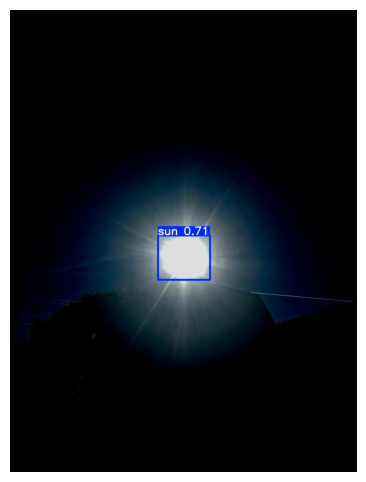

True

In [11]:
plot = result.plot()

# cv2_imshow(plot)

# cv2.imwrite("result_image.jpg", plot)


# Convert BGR image to RGB for matplotlib

plot_rgb = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)

# Display using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(plot_rgb)
plt.axis('off')
plt.show()

# Save the result
cv2.imwrite("result_image_1.jpg", plot)


## Pretrained Model Implementation

Static Models from roboflow web


| Model | mAP50-95 | Precision | Recall | Images | Type |
|-------|----------|-----------|--------|--------|------|
| Our YOLO model | 73.5% | 89.2% | 91.7% | 633 | YOLOv8 (custom trained) |
| solar-re1fe/1 | 96.8% | 95.2% | 94.3% | 2684 | Roboflow 3.0 Object Detection (Fast) |
| sun-tracking-photovoltaic-panel/1 | 98.2% | 93.7% | 93.7% | 196 | Roboflow 2.0 Object Detection (Fast) |
| sun-tracking/3 | 92.5% | 94.7% | 91.8% | 1090 | YOLOv5 Model Upload |
| sun-tracking-555mn/4 | 97.7% | 93.0% | 89.2% | 923 | YOLOv8n Model Upload |



1. **sun-tracking-555mn/4**
   - Best overall performance with 97.7% mAP
   - YOLOv8n architecture, which is lightweight and suitable for microcontrollers
   - Recently trained (2024-03-05)
   - Balanced dataset size (923 images)

2. **solar-re1fe/1**
   - High performance (96.8% mAP, 95.2% precision, 94.3% recall)
   - Largest dataset (2684 images), potentially good for generalization
   - Roboflow 3.0 Object Detection (Fast) may be suitable for microcontrollers

3. **sun-tracking-photovoltaic-panel/1**
   - Highest mAP (98.2%)
   - Roboflow 2.0 Object Detection (Fast) may work on microcontrollers
   - Limited dataset (196 images) might affect generalization

4. **sun-tracking/3**
   - Lowest mAP (92.5%) among the options
   - YOLOv5 architecture, which is generally suitable for microcontrollers
   - Decent dataset size (1090 images)


In [ ]:


# define the image url to use for inference
image_file = "test/1.jpg"
image = cv2.imread(image_file)

# load a pre-trained yolov8n model
model = get_model(model_id="sun-tracking-555mn/4", api_key=api_key)

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.
results = model.infer(image)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
annotated_image = bounding_box_annotator.annotate(
    scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

# display the image
sv.plot_image(annotated_image)

### Implementing Live Web Cam

#### Central Grid Vision

A central gride box which would determine the strongest position for the solar panel to position for maximum sunlight. The solar panel will follow and turn according to the distance between the central grid and the sun detected in camera

![image-1.png](https://github.com/somwrks/AI-Solar-Panel/blob/main/image-1.png?raw=true)

In [ ]:
def draw_central_box(frame, box_size=100):
    height, width = frame.shape[:2]
    center_x, center_y = width // 2, height // 2
    top_left = (center_x - box_size // 2, center_y - box_size // 2)
    bottom_right = (center_x + box_size // 2, center_y + box_size // 2)
    cv2.rectangle(frame, top_left, bottom_right, (0, 255, 0), 2)
    return top_left, bottom_right

def calculate_distance_to_box(sun_center, top_left, bottom_right):
    sun_x, sun_y = sun_center
    box_x_min, box_y_min = top_left
    box_x_max, box_y_max = bottom_right

    closest_x = max(box_x_min, min(sun_x, box_x_max))
    closest_y = max(box_y_min, min(sun_y, box_y_max))

    return sun_x - closest_x, sun_y - closest_y


Applying different image filters for detecting sun in various environments

In [ ]:
def apply_sun_filter(frame):
    # Convert to float32 for better precision in calculations
    img = cv2.convertScaleAbs(frame, alpha=1.2)

    # Convert to HSV for better control
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    #  contrast enhancement
    hsv[:,:,2] = cv2.convertScaleAbs(hsv[:,:,2], alpha=-0.40)


    # # Convert back to BGR
    filtered = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return filtered

Adding Sun's position to adjust detection frequency based on sun movement to optimize power usage


In [ ]:
def calculate_sun_movement(lat, lon, time1, time2):
    pos1 = get_position(time1, lat, lon)
    pos2 = get_position(time2, lat, lon)
    movement = math.sqrt((pos2['azimuth'] - pos1['azimuth'])**2 + (pos2['altitude'] - pos1['altitude'])**2)
    return math.degrees(movement)

def calculate_detection_interval(lat, lon, current_time):
    future_time = current_time + timedelta(minutes=5)
    movement = calculate_sun_movement(lat, lon, current_time, future_time)  # Check movement over 5 minutes
    if movement > 1:  # If sun moves more than 1 degree in 5 minutes
        return 60  # Check every minute
    elif movement > 0.5:  # If sun moves more than 0.5 degrees in 5 minutes
        return 180  # Check every 3 minutes
    else:
        return 300  # Check every 5 minutes


Activating the camera only when needed for detection to conserve energy.


In [ ]:
def turn_off_camera(cap):
    cap.release()
    print("Camera turned off.")

def turn_on_camera():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Failed to turn on the camera.")
    else:
        print("Camera turned on.")
    return cap

### Setting up pipeline

In [ ]:
# Load the pre-trained model
model = get_model(model_id="sun-tracking-555mn/4", api_key=api_key)

# Create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Get current location
g = geocoder.ip('me')
latitude, longitude = g.latlng

print(f"Current location: {g.city}, {g.state}, {g.country}")
print(f"Latitude: {latitude}, Longitude: {longitude}")

# Initial sun detection
sun_detected = False
cap = turn_on_camera()

while not sun_detected and cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    filtered_frame = apply_sun_filter(frame)
    top_left, bottom_right = draw_central_box(filtered_frame)
    results = model.infer(filtered_frame)[0]
    detections = sv.Detections.from_inference(results)

    if len(detections) > 0:
        sun_detected = True
        for bbox in detections.xyxy:
            sun_center = ((bbox[0] + bbox[2])//2, (bbox[1] + bbox[3])//2)
            dx, dy = calculate_distance_to_box(sun_center, top_left, bottom_right)
            print(f"Initial Sun Detection - Time: {time.strftime('%H:%M:%S')}, dx: {dx}, dy: {dy}")
    else:
        print("Searching for sun...")

    annotated_frame = bounding_box_annotator.annotate(scene=filtered_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections)
    cv2.imshow("Initial Sun Detection", annotated_frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

turn_off_camera(cap)

if sun_detected:
    print("Sun detected. Starting interval-based tracking.")
    detection_interval = calculate_detection_interval(latitude, longitude, datetime.now(timezone.utc))
    last_detection_time = time.time()

    while True:
        current_time = time.time()

        if current_time - last_detection_time >= detection_interval:
            cap = turn_on_camera()
            if cap.isOpened():
                ret, frame = cap.read()
                if ret:
                    filtered_frame = apply_sun_filter(frame)
                    top_left, bottom_right = draw_central_box(filtered_frame)
                    results = model.infer(filtered_frame)[0]
                    detections = sv.Detections.from_inference(results)

                    if len(detections) > 0:
                        for bbox in detections.xyxy:
                            sun_center = ((bbox[0] + bbox[2])//2, (bbox[1] + bbox[3])//2)
                            dx, dy = calculate_distance_to_box(sun_center, top_left, bottom_right)
                            print(f"Time: {time.strftime('%H:%M:%S')}, dx: {dx}, dy: {dy}")

                            detection_interval = calculate_detection_interval(latitude, longitude, datetime.now(timezone.utc))
                    else:
                        print("Sun not detected")

                    annotated_frame = bounding_box_annotator.annotate(scene=filtered_frame, detections=detections)
                    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections)
                    cv2.imshow("Filtered Detection", annotated_frame)

                turn_off_camera(cap)

            last_detection_time = current_time

        time.sleep(1)  # Sleep for 1 second to reduce CPU usage

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cv2.destroyAllWindows()